# CNN e Transfer Learning
#### Aluna: Cecília Regina Oliveira de Assis - 2019697720
#### Professor: Adriano Veloso

In [0]:
from math import ceil

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython.display import display
from IPython.display import Markdown

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# Tira os warning do TF
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

mpl.rc('font', **{'size': 14})

In [0]:
# Define a quantidade de epocas da CNN
EPOCHS     = 20

## Resumo dos Dados

O conjunto de dados utilizado se chama **CIFAR-10**. O mesmo corresponte a uma coleção de 60000 imagens coloridas de tamanho 32x32, sendo 50000 de treino e 10000 de teste. Cada imagem pode pertencer a uma das 10 classes previamente definidas e numeradas de 0 a 9.  As classes são: airplane, automobile, bird,cat, deer, dog, frog, horse, ship e truck. O dataset pode ser baixado facilmente pelo Keras.

In [0]:
# Importa o conjunto de dados do KERAS
from keras.datasets import cifar10

# Carrega as imagens em conjuntos separados de treino e teste
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Define um vetor de classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

# Remove a dimensão extra nos conjuntos de output
y_train = y_train.flatten()
y_test  = y_test.flatten()

### Exemplos de imagens

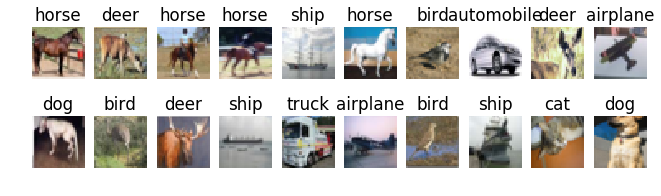

In [8]:
n_rows    = 2
n_cols    = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(11,3))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, x_train.shape[0])
        axes[i][j].imshow(x_train[img_i])
        axes[i][j].set_title("{}".format(classes[y_train[img_i]]))
        axes[i][j].axis("off")

## Preprocessamento

### Separação das partes A e B

In [0]:
# Define função que separa os conjuntos de dados em partes A e B
def split_dataset(x_train, y_train):
  y_train_encoded = pd.get_dummies(y_train).values
  
  a_x_train = []
  a_y_train = []
  b_x_train = []
  b_y_train = []
  for i in range(x_train.shape[0]):
    x = x_train[i]
    y = y_train[i]
    if y == 0 or y == 2:
      b_x_train.append(x)
      b_y_train.append(y_train_encoded[i])
    else:
      a_x_train.append(x)
      a_y_train.append(y_train_encoded[i])   
      
  a_x_train = np.asarray(a_x_train, dtype='float32')
  a_y_train = np.asarray(a_y_train)
  b_x_train = np.asarray(b_x_train, dtype='float32')
  b_y_train = np.asarray(b_y_train)
  
  return a_x_train, a_y_train, b_x_train, b_y_train

In [0]:
# One-hot encoding dos targets
y_test = pd.get_dummies(y_test).values

# Normaliza os pixels entre 0 e 1
x_train  = x_train.astype('float32')
x_test   = x_test.astype('float32')
x_train /= 255
x_test  /= 255

# Separação dos conjuntos de dados
a_x_train, a_y_train, b_x_train, b_y_train = split_dataset(x_train, y_train)

# Pega o número de classes
n_classes = y_test.shape[1]

## Visualização dos resultados

In [0]:
# Define uma função que gera e apresenta graficos dos resultados de treino
def plot_graph(history, title):
  fig, axes = plt.subplots(1, 2, figsize=(15, 7))
  
  # Define titulo do grafico
  fig.suptitle(title, fontsize=20, fontweight='bold')
  
  # Loss
  axes[0].plot(range(1, len(history.history["loss"])+1), 
               history.history["loss"], 
        label="Train Loss", color="royalblue", lw=3)
  axes[0].set_ylabel("Loss")
  axes[0].set_xlabel("Epoch")
  axes[0].set_xticks(range(1, len(history.history["acc"])+1))
  axes[0].legend()
  
  # Accuracy
  axes[1].plot(range(1, len(history.history["acc"])+1), 
               history.history["acc"], 
          label="Train ACC", color="royalblue", lw=3)
  axes[1].plot(range(1, len(history.history["val_acc"])+1), 
               history.history["val_acc"], 
          label="Test ACC", color="forestgreen", lw=3)
  axes[1].set_ylabel("Accuracy")
  axes[1].set_xlabel("Epoch")
  axes[1].set_xticks(range(1, len(history.history["acc"])+1))
  axes[1].legend()
  plt.show()

In [0]:
# Define uma função que gera e apresenta a matrix de confusão do modelo
def plot_matrix(model):
  # Predições
  y_proba = model.predict(x_test)
  y_pred  = np.argmax(y_proba, axis=1)

  # Labels (desfaz o one-hot encode)
  y_true  = np.argmax(y_test, axis=1)

  cm = metrics.confusion_matrix(y_true, y_pred)
  classes = list(range(0, 10))
  fig, ax = plt.subplots(figsize=(7, 7))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         xticklabels=classes, yticklabels=classes,
         title="Matriz de Confusão",
         ylabel="Real",
         xlabel="Predito")

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], "d"),
                  ha="center", va="center",
                  color="white" if cm[i, j] > cm.max()/2. else "black")
  fig.tight_layout()
  plt.show()

## Modelo parte A

### Definição da CNN

In [13]:
img_shape = a_x_train.shape[1:]

# Instanciação do modelo
part_a_model = Sequential()

# Parte de extração de features: convolução e pooling
part_a_model.add(Conv2D(8, kernel_size=(3,3), 
                 activation='relu', input_shape=img_shape, name='Conv1_A'))
part_a_model.add(Conv2D(8, kernel_size=(3,3), activation='relu', name='Conv2_A'))
part_a_model.add(MaxPooling2D(pool_size=(2, 2), name='Pool1_A'))

part_a_model.add(Conv2D(16, kernel_size=(3,3), activation='relu', name='Conv3_A'))
part_a_model.add(Conv2D(16, kernel_size=(3,3), activation='relu', name='Conv4_A'))
part_a_model.add(MaxPooling2D(pool_size=(2, 2), name='Pool2_A'))


# Camada que transforma os vetores 3D em 1D
part_a_model.add(Flatten(name='Flat_A'))

# Camadas fully connected 
part_a_model.add(Dense(32, activation="relu", name='Dense1_A'))
part_a_model.add(Dropout(0.4, name='Drop1_A'))

# Camada com ativacao softmax, que tem como saida uma probabilidade 
# para cada classe
part_a_model.add(Dense(n_classes, activation='softmax', name='Out_A'))

# Resumo do modelo
part_a_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_A (Conv2D)             (None, 30, 30, 8)         224       
_________________________________________________________________
Conv2_A (Conv2D)             (None, 28, 28, 8)         584       
_________________________________________________________________
Pool1_A (MaxPooling2D)       (None, 14, 14, 8)         0         
_________________________________________________________________
Conv3_A (Conv2D)             (None, 12, 12, 16)        1168      
_________________________________________________________________
Conv4_A (Conv2D)             (None, 10, 10, 16)        2320      
_________________________________________________________________
Pool2_A (MaxPooling2D)       (None, 5, 5, 16)          0         
_________________________________________________________________
Flat_A (Flatten)             (None, 400)               0         
__________

### Treinamento da CNN

In [14]:
# Inicializa o otimizados. Adam é uma variação do SGD
optimizer = optimizers.Adam(lr=0.0001)

# Compila o modelo, escolhendo a funcao de perda e a metrica principal
part_a_model.compile(optimizer, loss="categorical_crossentropy", 
                     metrics=["accuracy"])

# Treina por 20 épocas o modelo, com mini-batches de 128 exemplos
history = part_a_model.fit(a_x_train, a_y_train, batch_size=128, epochs=EPOCHS, 
                           validation_data=(x_test, y_test))

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 10s 244us/step - loss: 2.1963 - acc: 0.1307 - val_loss: 2.4636 - val_acc: 0.1281
Epoch 2/20
40000/40000 [==============================] - 2s 60us/step - loss: 2.0996 - acc: 0.1668 - val_loss: 2.4396 - val_acc: 0.1874
Epoch 3/20
40000/40000 [==============================] - 2s 59us/step - loss: 2.0108 - acc: 0.2142 - val_loss: 2.4490 - val_acc: 0.2361
Epoch 4/20
40000/40000 [==============================] - 2s 59us/step - loss: 1.8751 - acc: 0.2676 - val_loss: 2.5143 - val_acc: 0.2875
Epoch 5/20
40000/40000 [==============================] - 2s 60us/step - loss: 1.7569 - acc: 0.3141 - val_loss: 2.5279 - val_acc: 0.3204
Epoch 6/20
40000/40000 [==============================] - 2s 59us/step - loss: 1.6896 - acc: 0.3345 - val_loss: 2.5254 - val_acc: 0.3303
Epoch 7/20
40000/40000 [==============================] - 2s 61us/step - loss: 1.6406 - acc: 0.3538 - val_loss: 2.5501 - val_a

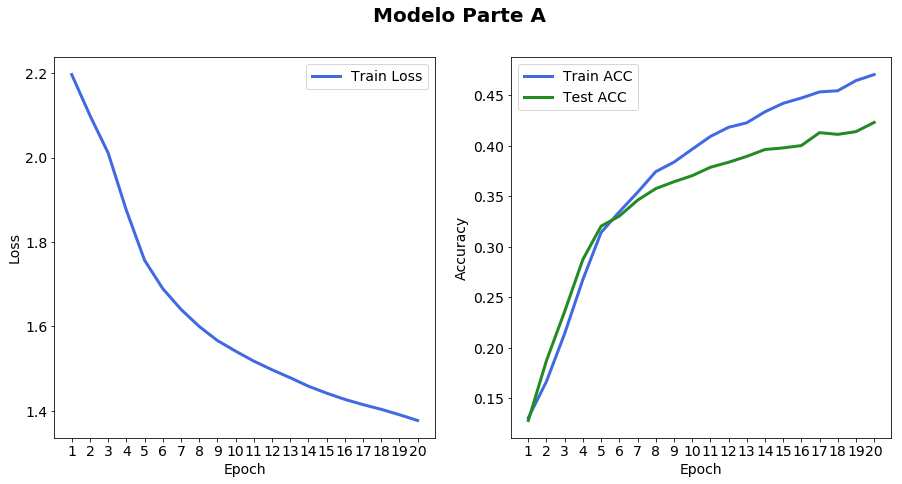

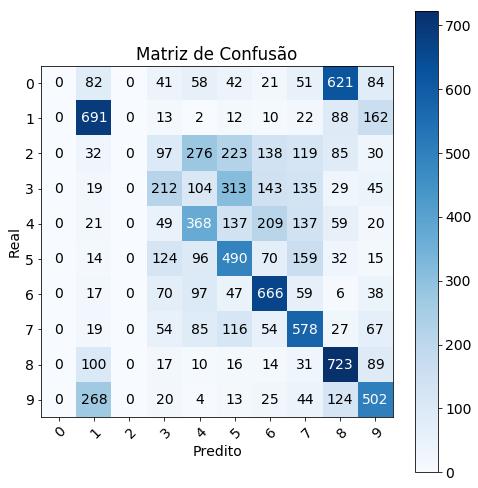

In [15]:
# Apresenta os resultados do modelo de forma gráfica
plot_graph(history, 'Modelo Parte A')
plot_matrix(part_a_model)

## Modelo parte B

### Sem Transfer Learning

#### Definição da CNN

In [16]:
img_shape = b_x_train.shape[1:]

# Instanciação do modelo
part_b_model = Sequential()

# Parte de extração de features: convolução e pooling
part_b_model.add(Conv2D(8, kernel_size=(3,3), 
                 activation='relu', input_shape=img_shape, name='Conv1_B'))
part_b_model.add(Conv2D(8, kernel_size=(3,3), activation='relu', name='Conv2_B'))
part_b_model.add(MaxPooling2D(pool_size=(2, 2), name='Pool1_B'))

part_b_model.add(Conv2D(16, kernel_size=(3,3), activation='relu', name='Conv3_B'))
part_b_model.add(Conv2D(16, kernel_size=(3,3), activation='relu', name='Conv4_B'))
part_b_model.add(MaxPooling2D(pool_size=(2, 2), name='Pool2_B'))

# Camada que transforma os vetores 3D em 1D
part_b_model.add(Flatten(name='Flat_B'))

# Camadas fully connected 
part_b_model.add(Dense(32, activation="relu", name='Dense1_B'))
part_b_model.add(Dropout(0.4, name='Drop_B'))

# Camada com ativacao softmax, que tem como saida uma probabilidade 
# para cada classe
part_b_model.add(Dense(n_classes, activation='softmax', name='Out_B'))

# Resumo do modelo
part_b_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_B (Conv2D)             (None, 30, 30, 8)         224       
_________________________________________________________________
Conv2_B (Conv2D)             (None, 28, 28, 8)         584       
_________________________________________________________________
Pool1_B (MaxPooling2D)       (None, 14, 14, 8)         0         
_________________________________________________________________
Conv3_B (Conv2D)             (None, 12, 12, 16)        1168      
_________________________________________________________________
Conv4_B (Conv2D)             (None, 10, 10, 16)        2320      
_________________________________________________________________
Pool2_B (MaxPooling2D)       (None, 5, 5, 16)          0         
_________________________________________________________________
Flat_B (Flatten)             (None, 400)               0         
__________

#### Treinamento da CNN

In [17]:
# Inicializa o otimizados. Adam é uma variação do SGD
optimizer = optimizers.Adam(lr=0.0001)

# Compila o modelo, escolhendo a funcao de perda e a metrica principal
part_b_model.compile(optimizer, loss="categorical_crossentropy", 
                     metrics=["accuracy"])

# Treina por 20 épocas o modelo, com mini-batches de 128 exemplos
history = part_b_model.fit(b_x_train, b_y_train, batch_size=128, epochs=EPOCHS, 
                           validation_data=(x_test, y_test))

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 1s 137us/step - loss: 2.1675 - acc: 0.4172 - val_loss: 2.3681 - val_acc: 0.1000
Epoch 2/20
10000/10000 [==============================] - 1s 80us/step - loss: 1.1771 - acc: 0.5091 - val_loss: 4.8267 - val_acc: 0.1106
Epoch 3/20
10000/10000 [==============================] - 1s 81us/step - loss: 0.8788 - acc: 0.5207 - val_loss: 5.4059 - val_acc: 0.1308
Epoch 4/20
10000/10000 [==============================] - 1s 81us/step - loss: 0.8029 - acc: 0.5417 - val_loss: 6.3517 - val_acc: 0.1468
Epoch 5/20
10000/10000 [==============================] - 1s 82us/step - loss: 0.7273 - acc: 0.6011 - val_loss: 7.6497 - val_acc: 0.1536
Epoch 6/20
10000/10000 [==============================] - 1s 83us/step - loss: 0.6386 - acc: 0.6832 - val_loss: 8.3201 - val_acc: 0.1589
Epoch 7/20
10000/10000 [==============================] - 1s 80us/step - loss: 0.5665 - acc: 0.7454 - val_loss: 9.4317 - val_ac

#### Visualização dos resultados de treino

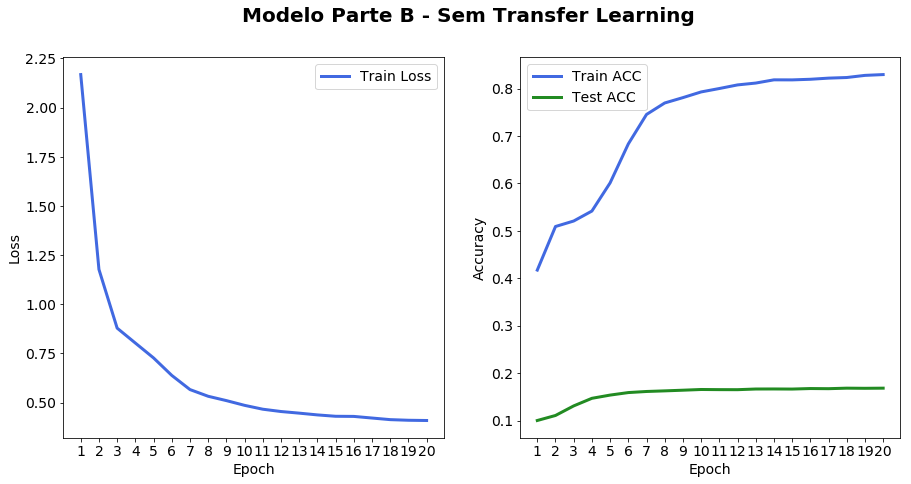

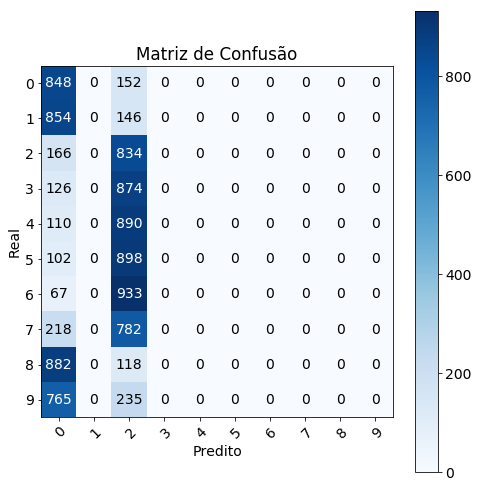

In [18]:
# Apresenta os resultados do modelo de forma gráfica
plot_graph(history, 'Modelo Parte B - Sem Transfer Learning')
plot_matrix(part_b_model)

In [0]:
# Predições
y_proba = part_b_model.predict(x_test)
y_pred = np.argmax(y_proba, axis=1)

# Labels (desfaz o one-hot encode)
y_true = np.argmax(y_test, axis=1)

### Fine Tunning em uma camada

#### Definição da CNN

In [20]:
part_b_model = part_a_model

# Remove a ultima camada FC do modelo já treinado na parte A
part_b_model.pop()

# Congela as camads do modelo parte A de forma que essas não seja treináveis
for layer in part_b_model.layers:
  layer.trainable = False

# Adicioana uma nova camada de output 
part_b_model.add(Dense(n_classes, activation='softmax', name='Output_B'))

# Inicializa o otimizados. Adam é uma variação do SGD
optimizer = optimizers.Adam(lr=0.0001)

# Compila o modelo, escolhendo a funcao de perda e a metrica principal
part_b_model.compile(optimizer, 
                     loss="categorical_crossentropy", 
                     metrics=["accuracy"])

# Resumo do modelo
print('Resumo do modelo parte A, após adição de nova última camada:')
part_b_model.summary()

Resumo do modelo parte A, após adição de nova última camada:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_A (Conv2D)             (None, 30, 30, 8)         224       
_________________________________________________________________
Conv2_A (Conv2D)             (None, 28, 28, 8)         584       
_________________________________________________________________
Pool1_A (MaxPooling2D)       (None, 14, 14, 8)         0         
_________________________________________________________________
Conv3_A (Conv2D)             (None, 12, 12, 16)        1168      
_________________________________________________________________
Conv4_A (Conv2D)             (None, 10, 10, 16)        2320      
_________________________________________________________________
Pool2_A (MaxPooling2D)       (None, 5, 5, 16)          0         
_________________________________________________________________
Flat_A (Flatten

#### Treinamento da CNN

In [21]:
# Treina por 20 épocas o modelo, com mini-batches de 128 exemplos
history = part_b_model.fit(b_x_train, b_y_train, batch_size=128, epochs=EPOCHS, 
                           validation_data=(x_test, y_test))

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 1s 101us/step - loss: 2.9884 - acc: 0.0847 - val_loss: 3.0024 - val_acc: 0.1537
Epoch 2/20
10000/10000 [==============================] - 1s 65us/step - loss: 2.7991 - acc: 0.1185 - val_loss: 2.9997 - val_acc: 0.1477
Epoch 3/20
10000/10000 [==============================] - 1s 66us/step - loss: 2.5945 - acc: 0.1610 - val_loss: 3.0064 - val_acc: 0.1427
Epoch 4/20
10000/10000 [==============================] - 1s 66us/step - loss: 2.4342 - acc: 0.2022 - val_loss: 3.0226 - val_acc: 0.1330
Epoch 5/20
10000/10000 [==============================] - 1s 67us/step - loss: 2.2608 - acc: 0.2500 - val_loss: 3.0482 - val_acc: 0.1242
Epoch 6/20
10000/10000 [==============================] - 1s 66us/step - loss: 2.1061 - acc: 0.3001 - val_loss: 3.0818 - val_acc: 0.1174
Epoch 7/20
10000/10000 [==============================] - 1s 67us/step - loss: 1.9720 - acc: 0.3324 - val_loss: 3.1241 - val_ac

#### Visualização dos resultados

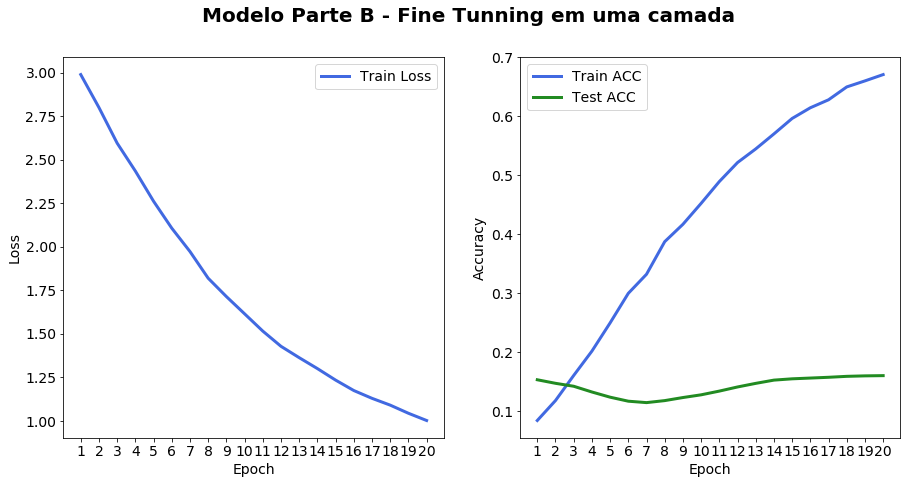

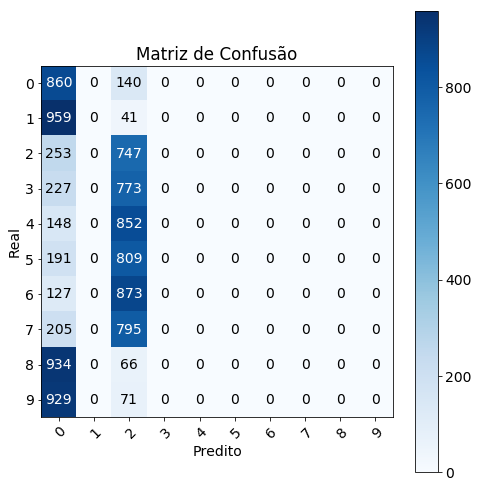

In [22]:
# Apresenta os resultados do modelo de forma gráfica
plot_graph(history, 'Modelo Parte B - Fine Tunning em uma camada')
plot_matrix(part_b_model)

### Fine Tunning em duas camadas

#### Definição da CNN

In [23]:
part_b_model = part_a_model

# Remove as duas últimas camadas FC e a camada de dropout
part_b_model.pop()
part_b_model.pop()
part_b_model.pop()

# Congela as camads do modelo parte A de forma que essas não seja treináveis
for layer in part_b_model.layers:
  layer.trainable = False

# Adicioana uma nova camada de output 
part_b_model.add(Dense(32, activation="relu", name='Dense1_B'))
part_b_model.add(Dropout(0.4, name='Drop_B'))
part_b_model.add(Dense(n_classes, activation='softmax', name='Output_B'))

# Inicializa o otimizados. Adam é uma variação do SGD
optimizer = optimizers.Adam(lr=0.0001)

# Compila o modelo, escolhendo a funcao de perda e a metrica principal
part_b_model.compile(optimizer, 
                     loss="categorical_crossentropy", 
                     metrics=["accuracy"])

# Resumo do modelo
print('Resumo do modelo parte A, após adição de nova última camada:')
part_b_model.summary()

Resumo do modelo parte A, após adição de nova última camada:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_A (Conv2D)             (None, 30, 30, 8)         224       
_________________________________________________________________
Conv2_A (Conv2D)             (None, 28, 28, 8)         584       
_________________________________________________________________
Pool1_A (MaxPooling2D)       (None, 14, 14, 8)         0         
_________________________________________________________________
Conv3_A (Conv2D)             (None, 12, 12, 16)        1168      
_________________________________________________________________
Conv4_A (Conv2D)             (None, 10, 10, 16)        2320      
_________________________________________________________________
Pool2_A (MaxPooling2D)       (None, 5, 5, 16)          0         
_________________________________________________________________
Flat_A (Flatten

#### Treinamento da CNN

In [24]:
# Treina por 20 épocas o modelo, com mini-batches de 128 exemplos
history = part_b_model.fit(b_x_train, b_y_train, batch_size=128, epochs=EPOCHS, 
                           validation_data=(x_test, y_test))

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 1s 118us/step - loss: 2.0082 - acc: 0.2533 - val_loss: 3.0160 - val_acc: 0.1432
Epoch 2/20
10000/10000 [==============================] - 1s 71us/step - loss: 1.0105 - acc: 0.6227 - val_loss: 4.9149 - val_acc: 0.1586
Epoch 3/20
10000/10000 [==============================] - 1s 69us/step - loss: 0.7358 - acc: 0.7084 - val_loss: 5.6500 - val_acc: 0.1621
Epoch 4/20
10000/10000 [==============================] - 1s 70us/step - loss: 0.6831 - acc: 0.7353 - val_loss: 6.1178 - val_acc: 0.1641
Epoch 5/20
10000/10000 [==============================] - 1s 72us/step - loss: 0.6362 - acc: 0.7449 - val_loss: 6.5325 - val_acc: 0.1654
Epoch 6/20
10000/10000 [==============================] - 1s 71us/step - loss: 0.6098 - acc: 0.7563 - val_loss: 6.8320 - val_acc: 0.1659
Epoch 7/20
10000/10000 [==============================] - 1s 69us/step - loss: 0.5770 - acc: 0.7724 - val_loss: 7.2164 - val_ac

#### Visualização dos resultados

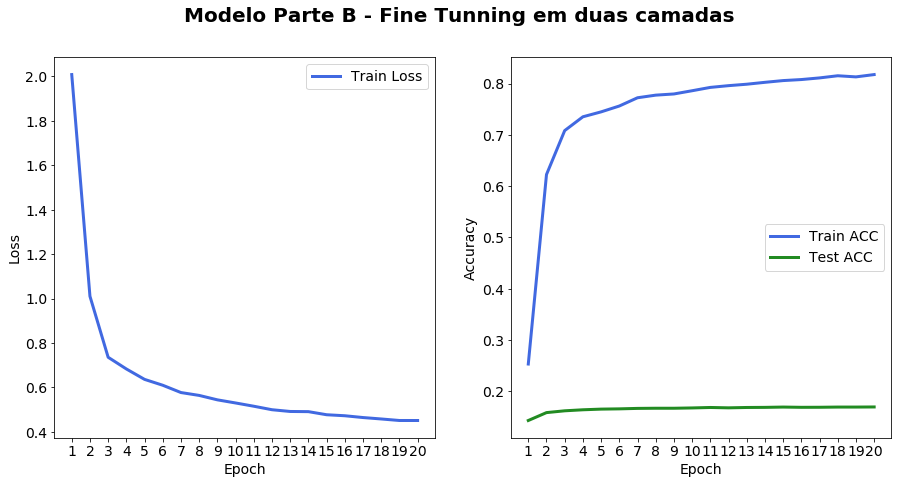

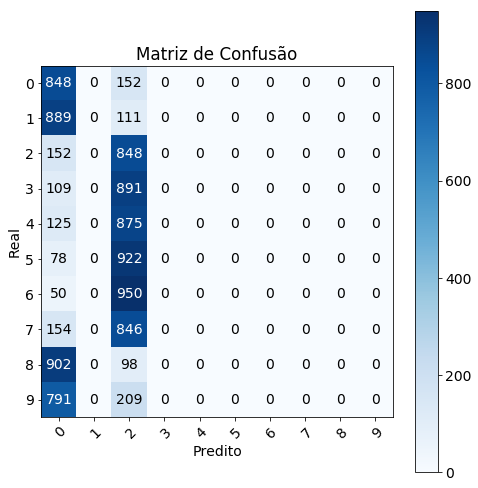

In [25]:
# Apresenta os resultados do modelo de forma gráfica
plot_graph(history, 'Modelo Parte B - Fine Tunning em duas camadas')
plot_matrix(part_b_model)

## Comparação dos resultados

Para desenvolvimento do trabalho três estratégias foram abordadas:
1. Não utilização do _Transfer Learning_
2._Transfer Learning_, com _Fine-tuning_ em na última camada da CNN
3. _Transfer Learning_, com _Fine-tuning_ em nas duas últimas camadas da CNN

A aplicação do _Transfer Learning_ objetiva o treinamento da rede a partir de pesos já estipulados, de modo que esta fase do modelo já comece de um ponto de partida mais relevante do que aquele aleatório.

A estratégia que apresentou maior acurácia de teste foi a 3ª, porém esta também exibiu a mais elevada incidência de overfitting sobre os dados. Ao adotar o   _Transfer Learning_, os resultados do modelo corroboraram com a premissa de que o uso da técnica possibilita maior efetividade das redes de aprendizado profundo.

Por fim, foi interessante notar que a rede treinada com a parte B dos dados, classes "0" e "2", não foi capaz de associar filtros (_features_) às imagens das demais classes, de forma similiar a CNN treinada com a parte A dos dados que operou de maneira complementar a anterior: não identificando padrão para as classes da parte B.